In [13]:
import cv2
import math
import numpy as np
from scipy.signal import *
import matplotlib.pyplot as plt
from imageio import imread
a = np.arange(25).reshape((5,5))
a

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [14]:
b = np.array([[-1/2,0,1/2]])
c = b.transpose()
c

array([[-0.5],
       [ 0. ],
       [ 0.5]])

In [18]:
x,y = np.gradient(a)
x

array([[5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5.],
       [5., 5., 5., 5., 5.]])

In [19]:
myx = convolve(a,b,mode='same')
myx

array([[ -0.5,  -1. ,  -1. ,  -1. ,   1.5],
       [ -3. ,  -1. ,  -1. ,  -1. ,   4. ],
       [ -5.5,  -1. ,  -1. ,  -1. ,   6.5],
       [ -8. ,  -1. ,  -1. ,  -1. ,   9. ],
       [-10.5,  -1. ,  -1. ,  -1. ,  11.5]])

In [21]:
myx = convolve(a,np.rot90(b),mode='same')
myx

array([[ 2.5,  3. ,  3.5,  4. ,  4.5],
       [ 5. ,  5. ,  5. ,  5. ,  5. ],
       [ 5. ,  5. ,  5. ,  5. ,  5. ],
       [ 5. ,  5. ,  5. ,  5. ,  5. ],
       [-7.5, -8. , -8.5, -9. , -9.5]])

In [76]:


def H(img_gray):
    hist, bin_edges = np.histogram(img_gray, bins=np.arange(257))
    bins = bin_edges[:-1]

    p = np.histogram(img_gray, bins=np.arange(257), density=True)[0]
    w_0 = p.cumsum();
    w_1 = 1 - w_0
    
    return (hist, bins, p, w_0, w_1)

def V(p, bins, w_0, w_1):
    v = np.empty(hist.shape)
    for t in range(256):
        m_0 = np.divide(np.sum(p[:t+1] * bins[:t+1]), w_0[t], where=w_0[t]!=0)
        m_1 = np.divide(np.sum(p[t+1:] * bins[t+1:]), w_1[t], where=w_1[t]!=0)
        v_0 = np.sum(((bins[:t+1] - m_0)**2) * p[:t+1])
        v_1 = np.sum(((bins[t+1:] - m_1)**2) * p[t+1:])
        v[t] = w_0[t] * v_0 + w_1[t] * v_1
    return v

def otsu(grey_img, threshold=None):
    binary_img = np.copy(grey_img)
    
    if threshold is None:
        hist, bins, p, w_0, w_1 = H(grey_img)
        v = V(p, bins, w_0, w_1)
        threshold = np.argmin(v)
    
    for i in range(binary_img.shape[0]):
        for j in range(binary_img.shape[1]):
            if binary_img[i][j] < threshold:
                binary_img[i][j] = 0
            else:
                binary_img[i][j] = 1

    return binary_img

In [77]:
def connected_component(grey_img):
    linked = {}
    labels = np.copy(grey_img)
    NextLabel = 1

    def find(x):
        if x!=linked[x]:
            linked[x]=find(linked[x]);
        return linked[x];

    def union(x, y):
        a=find(x)
        b=find(y)
        if a!=b:
            linked[b]=a;

    for i, row in enumerate(labels):
        for j, item in enumerate(row):
            if item != 0:
                # find neighbors
                neighbors = []
                if j-1>=0 and labels[i,j-1] != 0: 
                    neighbors.append((i,j-1))
                if i-1>=0 and j-1>=0 and labels[i-1,j-1] != 0: 
                    neighbors.append((i-1,j-1))
                if i-1>=0 and labels[i-1,j] != 0: 
                    neighbors.append((i-1,j))
                if i-1>=0 and j+1 < labels.shape[1] and labels[i-1,j+1] != 0: 
                    neighbors.append((i-1,j+1))
                # label
                if not neighbors:
                    linked[NextLabel] = NextLabel
                    labels[i,j] = NextLabel
                    NextLabel += 1
                else:
                    SmallestNeighbor = labels[neighbors[0]]
                    for neighbor in neighbors:
                        if labels[neighbor] < SmallestNeighbor:
                            SmallestNeighbor = labels[neighbor]
                    labels[i,j] = find(SmallestNeighbor)
                    for neighbor in neighbors:
                        union(SmallestNeighbor, labels[neighbor])
   
    # makes the labels sequential
    label_order = list(set(linked.values()))
    label_order.sort()
    for key, value in linked.items():
        linked[key] = label_order.index(value) + 1
    for i, row in enumerate(labels):
        for j, item in enumerate(row):
            if item != 0:
                labels[i,j] = linked[labels[i,j]]

    return labels

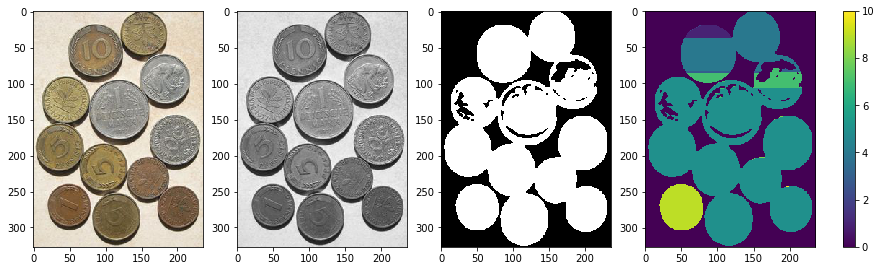

In [78]:
plt.gcf().set_size_inches(14,5)

plt.subplot(1,4,1)
img_coin = imread('coins_pix.jpg')
plt.imshow(img_coin)

plt.subplot(1,4,2)
img_coin_gray = cv2.imread('coins_pix.jpg',0)
plt.imshow(img_coin_gray,cmap='gray')

plt.subplot(1,4,3)
img_coin_gray_blur = cv2.GaussianBlur(img_coin_gray,(9,9),0)
hist, bins, p, w_0, w_1 = H(img_coin_gray_blur)
v = V(p, bins, w_0, w_1)
img_coin_bw = otsu(img_coin_gray_blur, np.argmin(v))
img_coin_bw_r = 1-img_coin_bw
plt.imshow(img_coin_bw_r,cmap='gray')

plt.gcf().add_axes([0.46, 0.175, 0.551, 0.655])
c = connected_component(img_coin_bw_r)
plt.imshow(c)
plt.colorbar()

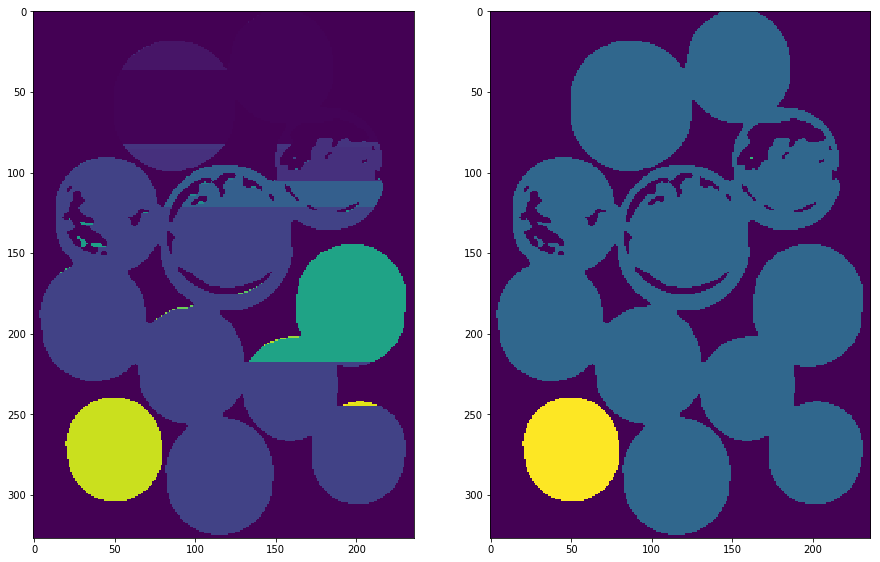

In [122]:
plt.gcf().set_size_inches(15,15)

plt.subplot(1,2,1)
grey_img = img_coin_bw_r

##########################################

linked = {}
labels = np.copy(grey_img)
NextLabel = 1

def find(x):
    if x!=linked[x]:
        linked[x]=find(linked[x]);
    return linked[x];

def union(x, y):
    a=find(x)
    b=find(y)
    if a!=b:
        linked[b]=a;

for i, row in enumerate(labels):
    for j, item in enumerate(row):
        if item != 0:
            # find neighbors
            neighbors = []
            if j-1>=0 and labels[i,j-1] != 0: 
                neighbors.append((i,j-1))
            if i-1>=0 and j-1>=0 and labels[i-1,j-1] != 0: 
                neighbors.append((i-1,j-1))
            if i-1>=0 and labels[i-1,j] != 0: 
                neighbors.append((i-1,j))
            if i-1>=0 and j+1 < labels.shape[1] and labels[i-1,j+1] != 0: 
                neighbors.append((i-1,j+1))
            # label
            if not neighbors:
                linked[NextLabel] = NextLabel
                labels[i,j] = NextLabel
                NextLabel += 1
            else:
                SmallestNeighbor = labels[neighbors[0]]
                for neighbor in neighbors:
                    if labels[neighbor] < SmallestNeighbor:
                        SmallestNeighbor = labels[neighbor]
                labels[i,j] = find(SmallestNeighbor)
                for neighbor in neighbors:
                    if SmallestNeighbor==0 or labels[neighbor]==0:
                        print('ERROR')
                    union(SmallestNeighbor, labels[neighbor])
                    
plt.imshow(labels)

for i, row in enumerate(labels):
    for j, item in enumerate(row):
        if labels[i,j]:
            labels[i,j] = find(labels[i,j])

# makes the labels sequential
label_order = list(set(linked.values()))
label_order.sort()
for key, value in linked.items():
    linked[key] = label_order.index(value) + 1
for i, row in enumerate(labels):
    for j, item in enumerate(row):
        if item != 0:
            labels[i,j] = linked[labels[i,j]]

plt.subplot(1,2,2)
plt.imshow(labels)